In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youth-mental-health-narratives-novel-variables/features_Z140Hep.csv


In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data = pd.read_csv('/kaggle/input/youth-mental-health-narratives-novel-variables/features_Z140Hep.csv')

In [4]:
# Data Cleaning
data['MentalHealthProblem'] = data['MentalHealthProblem'].astype(float)
data['DepressedMood'] = data['DepressedMood'].astype(float)
data['MentalIllnessTreatmentCurrnt'] = data['MentalIllnessTreatmentCurrnt'].astype(float)
data['HistoryMentalIllnessTreatmnt'] = data['HistoryMentalIllnessTreatmnt'].astype(float)
data['SuicideAttemptHistory'] = data['SuicideAttemptHistory'].astype(float)

In [5]:
numeric_columns = ['MentalHealthProblem', 'DepressedMood', 'MentalIllnessTreatmentCurrnt', 
                    'HistoryMentalIllnessTreatmnt']
X = data[numeric_columns]
y = data['SuicideAttemptHistory']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
selector = RFE(model, n_features_to_select=5)
selector = selector.fit(X, y)

feature_ranking = pd.DataFrame({'Feature': numeric_columns, 'Rank': selector.ranking_})
print(feature_ranking.sort_values(by='Rank'))


                        Feature  Rank
0           MentalHealthProblem     1
1                 DepressedMood     1
2  MentalIllnessTreatmentCurrnt     1
3  HistoryMentalIllnessTreatmnt     1


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: 0.7964285714285714


In [8]:
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score

best_rf = grid_search.best_estimator_
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='roc_auc')
print("Cross-Validated ROC AUC Scores:", cv_scores)
print("Mean ROC AUC Score:", cv_scores.mean())
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
print("ROC AUC Score on Test Set:", roc_auc_score(y_test, y_pred_proba))
print("F1 Score on Test Set:", f1_score(y_test, best_rf.predict(X_test)))


Cross-Validated ROC AUC Scores: [0.75531402 0.67333106 0.6890917  0.72135888 0.69713965]
Mean ROC AUC Score: 0.7072470614111885
ROC AUC Score on Test Set: 0.7391903145218115
F1 Score on Test Set: 0.0


In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
    ('svc', SVC(probability=True, random_state=0)),
    ('knn', KNeighborsClassifier())
]

meta_model = LogisticRegression()
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
print("Accuracy of Stacking Model:", accuracy_score(y_test, y_pred))
print("F1 Score of Stacking Model:", f1_score(y_test, y_pred))


Accuracy of Stacking Model: 0.7766666666666666
F1 Score of Stacking Model: 0.0


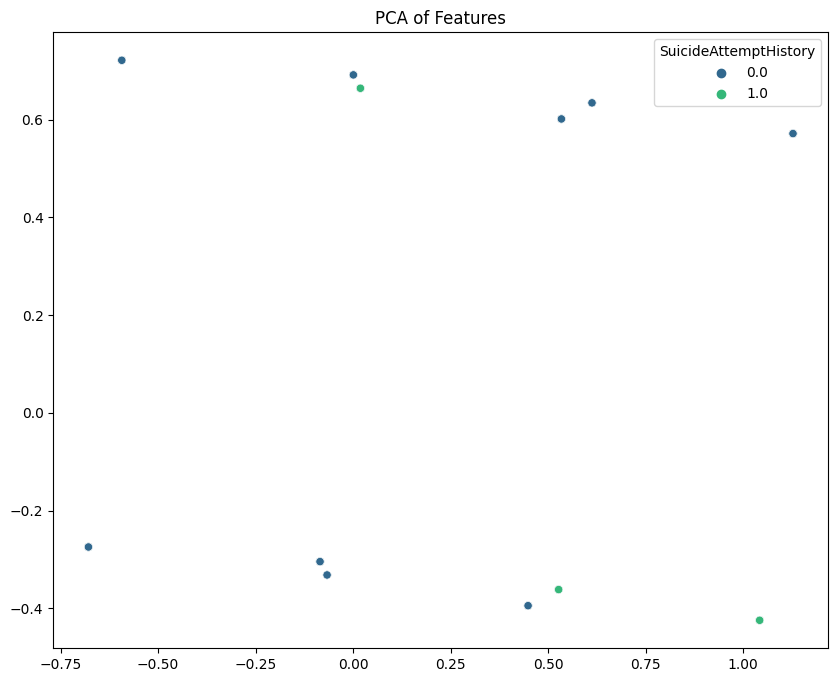

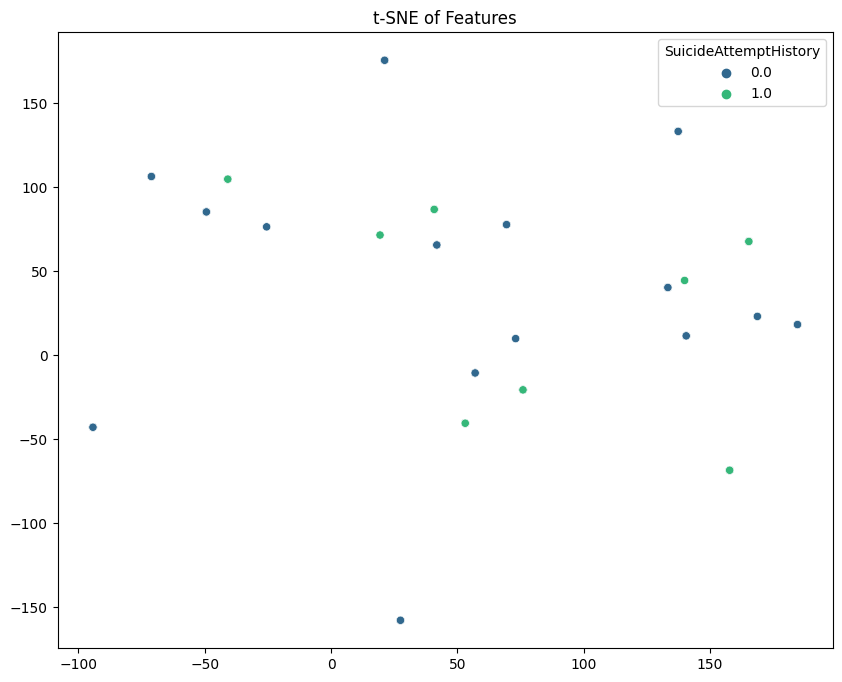

In [10]:
# Visualization
fig = px.histogram(data, x='SuicideAttemptHistory', color='SuicideAttemptHistory', color_discrete_sequence=px.colors.qualitative.Plotly, title='Distribution of Suicide Attempt History')
fig.show()

corr = data[numeric_columns].corr()
fig = px.imshow(corr, color_continuous_scale='RdBu_r', title='Correlation Heatmap')
fig.show()

fig = px.box(data, x='SuicideAttemptHistory', y='DepressedMood', title='Depressed Mood Distribution by Suicide Attempt History', color='SuicideAttemptHistory', color_discrete_sequence=px.colors.qualitative.Plotly)
fig.show()

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=y, palette='viridis')
plt.title('PCA of Features')
plt.show()

tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(X)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=y, palette='viridis')
plt.title('t-SNE of Features')
plt.show()
